## Screening task 1

Report with a plot, as a function of the number of layers, L, the minimum distance

$ d_{min} = min \lvert\lvert \: \lvert\Phi(\theta)\rangle - \lvert\Psi\rangle \lvert\lvert$



Where $\lvert\Psi\rangle$ is a randomly generated vector on 4 qubits. The right set of parameters $\theta_{i,n}$ can be found via any method of choice (e.g. grid-search or gradient descent).


In [21]:
import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.quantum_info.states.random import random_statevector
from qiskit.visualization import *
import itertools

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

## Utilities

### 1. Circuit definition

In [52]:
def u1(circuit,params):
    
    '''
    Odd Block that consists of a RZ gate parametrized 
    by the params (1xNqbits) arg and followed by Controlled-Z gates
    '''
    
    n_qubits = circuit.num_qubits
    for i in range(n_qubits):
        circuit.rz(params[i],i)

    for i in range(n_qubits-1):
        circuit.cz(0, i+1)
    for i in range(1,n_qubits-1):
        circuit.cz(1,i+1)
    for i in range(2,n_qubits-1):
        circuit.cz(2,i+1)

def u2(circuit,params):
    
    ''' 
    Even Block that consists of RX gates 
    parametrized  by the params (Nqbitsx1) arg
    '''
    
    n_qubits = circuit.num_qubits
    for i in range(n_qubits):
        circuit.rx(params[i],i)

class qVariationalCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the even/odd block variational ansatz
    """
    
    def __init__(self, n_qubits,ansatz,num_layers, backend, shots):
        
        # --- Initialize to |0> statevector ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.ansatz = ansatz
        self.backend = backend
        self.shots = shots
        self.num_layers = num_layers
        
    def construct_var_form(self,params):
        
        '''
        - params: n_qubits x num_layers
        - A layer consists of odd and even block , e.g. U1+U2, parametrized by the n_qbits x 1 theta vector
        '''
        evenBlock = self.ansatz[0]
        oddBlock = self.ansatz[1]
        
        for l in range(0,self.num_layers):
            
            evenBlock(self._circuit,params[:,l])
            oddBlock(self._circuit,params[:,l])    

        self._circuit.measure_all()
    
    def run(self,params):
        
        self.construct_var_form(params)
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots)
        result = job.result()

        return result

    
      

### 2. Objective function for the optimization problem

In [60]:
def get_probability_distribution(counts):
    '''
    This function normalizes the histogram of counts, 
    effectively turning it into a probability distribution array
    
    Counts: Dictionary object with basis state and their ocurrences
    '''

    basis_states = list(itertools.product([0,1], repeat = n_qubits))
    
    int_count = []
    for outcome in basis_states:
        bstr = "".join(str(x) for x in outcome)
        if bstr not in counts.keys():
            counts[bstr] = 0
        int_count.append((int(bstr,2),counts[bstr]))
        
    states_ocurrences = sorted(int_count,key=lambda x: x[0], reverse=False)
    ocurrences = [x[1] for x in states_ocurrences]
    output_distr = [v / NUM_SHOTS for v in ocurrences]

    
    if len(output_distr) == 1:
        output_distr.append(0)

    return output_distr


def objective_function(params):
    """
    It performs:
     1. Obtain a quantum circuit instance from the parameters
     2. Obtain the counts for each measured state, and convert those counts into a probability vector
     3. Calculate amd return the cost as the distance between the output state distr and the target random state distr
    """
    var_circuit = qVariationalCircuit(n_qubits,var_form,num_layers,simulator,NUM_SHOTS)
    params = params.reshape(n_qubits,num_layers)
    result = var_circuit.run(params)
    output_distr = get_probability_distribution(result.get_counts(var_circuit._circuit))
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2**n_qubits)])
    
    return cost  


## Experiment

**Main objective**: Exploring how the number of variational layers, among other heuristics, affects this generative modelling task.

In the following cell, the hybrid quantum-classical optimization loop is executed. To take into account parameter initialization, the average of the mininum distance error between learned and target quantum state probabilities is computed with few runs of the stochastic environment of running the hybrid optimization loop, that is what is reported as mininum distance on the plots. 

** DISCLAIMER ABOUT MY APPROACH**

When only having access to outcomes of measurements on a quantum computer, a valid metric is the norm of the difference of the  discrete  quantum state probability  distributions,  as a proxy for calculating some 'distance' between quantum states, although this probability distance measure generally loses the phase information of quantum states. Here it is expressed:

$ pdist_{min} = min \lvert\lvert \:p_{\phi}(\theta) - p_{\psi} \lvert\lvert$

Where $p_{\phi}(\theta) = \lvert \Phi(\theta) \lvert^{2}$ and $p_{\psi} = \lvert \Psi \lvert^{2}$ are the parametrized and target probability distribution of their quantum states respectively. In this case, I use the $l_{1}$ norm, which is the absolute value of the difference.


I recall the swap test as tool to compute the overlap between quantum states, which might be a better defintion of "distance". Notice this is quite different from the defined probability distance.

I finally decided to use a quantum simulator that only gives access to the outcomes of measurements and measure the probability distance proxy as the cost function.

Optimizer note: 

The SPSA and COBYLA optimizers use numerical gradient approximation techniques to compute the gradient of the objective function. The main feature of SPSA is the gradient approximation, which requires only two measurements of the objective function, regardless of the dimension of the optimization problem. While the COBYLA optimizer only requires one measurement.


The optimizer: COBYLA

The ansatz architecture: RZ-CZ-RX
AvgMinDist: 0.5987301849622286 for num of layers: L = 1
AvgMinDist: 0.4923004015028415 for num of layers: L = 2
AvgMinDist: 0.4284890808966296 for num of layers: L = 3
AvgMinDist: 0.48403227571561125 for num of layers: L = 4
AvgMinDist: 0.4208732410756905 for num of layers: L = 5
AvgMinDist: 0.43841852092599726 for num of layers: L = 6
AvgMinDist: 0.3020477775471982 for num of layers: L = 7
AvgMinDist: 0.3123250440210885 for num of layers: L = 8
AvgMinDist: 0.41045245732628083 for num of layers: L = 9
AvgMinDist: 0.2886902189602719 for num of layers: L = 10

The optimizer: SPSA

The ansatz architecture: RZ-CZ-RX
AvgMinDist: 0.8340237436460558 for num of layers: L = 1
AvgMinDist: 0.4330938133781096 for num of layers: L = 2
AvgMinDist: 0.519467346678435 for num of layers: L = 3
AvgMinDist: 0.3697078018622072 for num of layers: L = 4
AvgMinDist: 0.46380183937467334 for num of layers: L = 5
AvgMinDist: 0.4399479614345883 for num of 

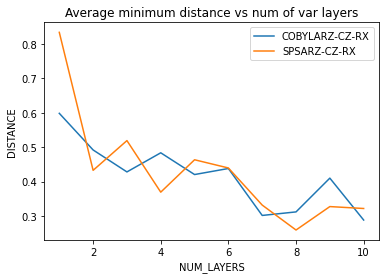

In [61]:
#-------------------------------INIT PARAMETERS------------------------------------
n_qubits = 4
MAX_LAYERS = 10
N_TRIALS = 5
NUM_SHOTS = 1024
N_ITERS = 1000
simulator = qiskit.Aer.get_backend('qasm_simulator')
variational_forms = {'RZ-CZ-RX': [u1,u2]}
optimizers = ['COBYLA','SPSA']
fig, ax = plt.subplots()


#-----------------GRID SEARCH FOR OPTIMIZERS CLASS AND NUM OF VARIATIONAL LAYERS---------------

for name_opt in optimizers:
    
    print()
    print('The optimizer: {}'.format(name_opt))
    print()
    
    for var_name, var_form in variational_forms.items():
        
        print('The ansatz architecture: {}'.format(var_name))
        
        MinDistError_vs_numlayers = []

        for num_layers in range(1,MAX_LAYERS+1):

            MinDistError = []

            if name_opt == 'SPSA':
                opt = SPSA(maxiter=N_ITERS)
            elif name_opt == 'COBYLA':
                opt = COBYLA(maxiter= N_ITERS)    

            for trial in range(0,N_TRIALS):

                # Re-seed the PRNG to have different initial angle parameter
                np.random.seed() 
                initial_params = 2*np.pi*np.random.rand(n_qubits,num_layers)
                target_distr = random_statevector(2**n_qubits).probabilities(range(n_qubits))
                ret = opt.optimize(num_vars= np.prod(initial_params.shape), objective_function=objective_function, initial_point=initial_params.flatten())
                MinDistError.append(ret[1])

            avg_MinDistError = np.mean(MinDistError)
            print('AvgMinDist: {} for num of layers: L = {}'.format(avg_MinDistError,num_layers))
            MinDistError_vs_numlayers.append(avg_MinDistError)

        ax.plot(range(1,MAX_LAYERS+1),MinDistError_vs_numlayers,label=name_opt+' '+var_name)

leg = ax.legend();
ax.set_title('Average minimum distance vs num of var layers')
ax.set_xlabel('NUM_LAYERS')
ax.set_ylabel('DISTANCE');
fig.savefig('plot_MinDistvsNumLayers_shots{}_iters{}.png'.format(NUM_SHOTS,N_ITERS))

### Bonus question

Let's try a different set of parametrized rotation gates, picking up combinations from the {X,Y,Z} rotations, and  changing the entangling newtork of Controlled-Z gates for CNOT gates with only nearest neighbor qubit interaction, to emulate a simpler connectivity scheme on the quantum hardware. Another interesting trial is to eliminate the entangling network and have only rotations Paulis.

In [64]:
# Let's define more variational blocks

def u3(circuit,params):
    
    n_qubits = circuit.num_qubits
    for i in range(n_qubits):
        circuit.rz(params[i],i)
    for i in range(n_qubits):
        circuit.cnot(i,(i+1) % n_qubits)
    
def u4(circuit,params):
    
    n_qubits = circuit.num_qubits
    for i in range(n_qubits):
        circuit.rz(params[i],i)
        
    for i in range(n_qubits):
        circuit.cnot(i,(i+1) % n_qubits)
        
def u5(circuit,params):
    
    n_qubits = circuit.num_qubits
    
    for i in range(n_qubits):
        circuit.ry(params[i],i)


The optimizer: COBYLA

	 The ansatz architecture: RZ-CZ-RX

	 AvgMinDist: 0.6381496071757158 for num of layers: L = 1
	 AvgMinDist: 0.6030920642979425 for num of layers: L = 2
	 AvgMinDist: 0.3881238119065461 for num of layers: L = 3
	 AvgMinDist: 0.44741964235481724 for num of layers: L = 4
	 AvgMinDist: 0.3199422735839618 for num of layers: L = 5
	 The ansatz architecture: RZ-CX-RX

	 AvgMinDist: 0.5982060268423044 for num of layers: L = 1
	 AvgMinDist: 0.5784138261409151 for num of layers: L = 2
	 AvgMinDist: 0.5475058039982208 for num of layers: L = 3
	 AvgMinDist: 0.4434279402974338 for num of layers: L = 4
	 AvgMinDist: 0.364828429335493 for num of layers: L = 5
	 The ansatz architecture: RY-RX

	 AvgMinDist: 0.7335608135923212 for num of layers: L = 1
	 AvgMinDist: 0.5749946024523365 for num of layers: L = 2
	 AvgMinDist: 0.5891747173967208 for num of layers: L = 3
	 AvgMinDist: 0.5538500252725721 for num of layers: L = 4
	 AvgMinDist: 0.5872451015550716 for num of layers: L = 

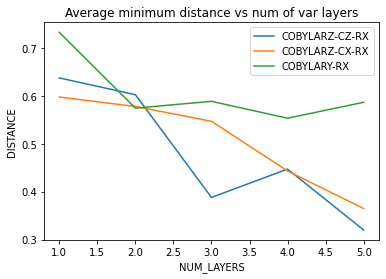

In [65]:
#-------------------------------INIT PARAMETERS------------------------------------

n_qubits = 4
MAX_LAYERS = 5
N_TRIALS = 10
NUM_SHOTS = 1024
N_ITERS = 500
simulator = qiskit.Aer.get_backend('qasm_simulator')
optimizers = ['COBYLA']
variational_forms = {'RZ-CZ-RX': [u1,u2], 'RZ-CX-RX': [u3,u2],'RY-RX':[u5,u2]}

fig, ax = plt.subplots()


#-----------------GRID SEARCH FOR OPTIMIZERS CLASS, ANSATZS AND NUM OF VARIATIONAL LAYERS---------------

for name_opt in optimizers:
    
    print()
    print('The optimizer: {}'.format(name_opt))
    print()
    
    for var_name, var_form in variational_forms.items():
        
        print('\t The ansatz architecture: {}\n'.format(var_name))
        
        MinDistError_vs_numlayers = []

        for num_layers in range(1,MAX_LAYERS+1):

            MinDistError = []

            if name_opt == 'SPSA':
                opt = SPSA(maxiter=N_ITERS)
            elif name_opt == 'COBYLA':
                opt = COBYLA(maxiter= N_ITERS)    

            for trial in range(0,N_TRIALS):

                # Re-seed the PRNG to have different initial angle parameter
                np.random.seed() 
                initial_params = 2*np.pi*np.random.rand(n_qubits,num_layers)
                target_distr = random_statevector(2**n_qubits).probabilities(range(n_qubits))
                ret = opt.optimize(num_vars= np.prod(initial_params.shape), objective_function=objective_function, initial_point=initial_params.flatten())
                MinDistError.append(ret[1])

            avg_MinDistError = np.mean(MinDistError)
            print('\t AvgMinDist: {} for num of layers: L = {}'.format(avg_MinDistError,num_layers))
            MinDistError_vs_numlayers.append(avg_MinDistError)

        ax.plot(range(1,MAX_LAYERS+1),MinDistError_vs_numlayers,label=name_opt+var_name)

leg = ax.legend();
ax.set_title('Average minimum distance vs num of var layers')
ax.set_xlabel('NUM_LAYERS')
ax.set_ylabel('DISTANCE');
fig.savefig('plot_MinDistvsNumLayers_ansatzs_shots{}_iters{}.png'.format(NUM_SHOTS,N_ITERS))

## Conclusions

The heuristics of this hybrid quantum-classical loop that learns a target probability distribution are the following:

- **NUM_SHOTS**: Number of output measurements to estimate the output probability distribution
- **N_TRIALS**: Number of samples to estimate the distribution manhattan distance error. In each trial, a different    set of initial angle parameters is randonly generated.
- **N_LAYERS**: Number of layers or depth of quantum variational, a.k.a the number of repeated even/odd blocks. It can be translated to  the number of trainable quantum parameters  through Nqubits*(L) , where L is the number of repeated U1+U2 blocks.

Let's discuss in more detail , others heuristics that are essential when designing quantum models

**Ansatz choice (Bonus question)**:

It is interesting to see what is the effect of the entangling network on the capacity or power of quantum variational circuits. Substituing the CZ  tework for CNOT's does not significantly decrease performance and it is good news because the CNOT network is less costly than the CZ network in terms of hardware efficiency. Variational layers made of only Pauli rotations clearly are beaten by ansatz tha contain entagling layers, thus reinforcing the idea that PQC models hould contain these entagling networks.

I wonder if variational circuits need to be made of classically intractable circuits that are still ansatz-hardware efficient, so that the number of parameters scales polynominally with qubit count. The capacity to explore a vast dimension of the Hilbert space with such short depth circuits looks a like a good venue to research quantum models. Who knows if this quantum models executed on NISQ computers might beat classical SOTA neural networks on the near future , or we still are very far from the breakpoint.

**Optimizer performance**:

The SPSA optimizer is clearly slower than COBYLA on this ideal quantum simulator . It is reported within the academic community that SPSA is best when conditions are noisy. Given that both optimizers perform fairly similar, COBYLA should be the optimizer of choice because its faster execution for the same number of iterations.

## Sources


- SPSA info: https://www.jhuapl.edu/SPSA/ , https://qiskit.org/documentation/_modules/qiskit/aqua/components/optimizers/spsa.html#SPSA.optimize

- Variational circuits and related: https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html, https://github.com/sonamghosh/quantum-machine-learning/blob/master/07_Variational_Circuits/07_Variational_Circuits.ipynb, https://qiskit.org/textbook/ch-applications/vqe-molecules.html#example

- Study of performance of optimizers and hybrid quantum classical heuristics : https://arxiv.org/pdf/1805.12037.pdf

- How to benchmark parameterized circuits (circuit expression capacity) : https://medium.com/qiskit/we-need-new-language-to-discuss-parameterized-quantum-circuits-60672f189b5f, Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms -> https://arxiv.org/abs/1905.10876

- Great summary about PQC models: https://arxiv.org/pdf/1906.07682.pdf


In [31]:
def u1(circuit,params):
    
    '''
    Odd Block that consists of a RZ gate parametrized 
    by the params (1xNqbits) arg and followed by Controlled-Z gates
    '''
    
    n_qubits = circuit.num_qubits
    for i in range(n_qubits):
        circuit.rz(params[i],i)

    for i in range(n_qubits-1):
        circuit.cz(0, i+1)
    for i in range(1,n_qubits-1):
        circuit.cz(1,i+1)
    for i in range(2,n_qubits-1):
        circuit.cz(2,i+1)

        
params = [0,1,2,3]
n_qubits = 4
circ = qiskit.QuantumCircuit(n_qubits)

u1(circ,params)

In [32]:
# Checking circuit architecture is alright

circ.draw()

┌───────┐                  
q_0: ┤ RZ(0) ├─■──■──■──────────
     ├───────┤ │  │  │          
q_1: ┤ RZ(1) ├─■──┼──┼──■──■────
     ├───────┤    │  │  │  │    
q_2: ┤ RZ(2) ├────■──┼──■──┼──■─
     ├───────┤       │     │  │ 
q_3: ┤ RZ(3) ├───────■─────■──■─
     └───────┘